In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

#Importamos las librerías que vamos a usar
from pathlib import Path
import json
import pickle
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from src.models.decision_transformer import DecisionTransformer
from reference_code.dt_reference import DecisionTransformerReference
from src.models.baselines import PopularityRecommender

from scripts.evaluation import evaluate_model_batched


# Reproducibilidad
torch.manual_seed(42)
np.random.seed(42)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experimentos de return conditioning 

In [5]:
# Rutas
test_path = "../data/test_users/netflix8_test.json"

final_model_path = "../results/trained_models/trained_model_refactored.pt"
reference_model_path = "../reference_code/trained_model_reference.pt"

# Cargar usuarios de test
with open(test_path, "r") as f:
    test_users = json.load(f)
    
# Cargar trayectorias de entrenamiento normalizadas
train_trajectories_path = "../data/processed/trajectories_train.pkl"
with open(train_trajectories_path, "rb") as f:
    train_trajectories = pickle.load(f)

In [6]:
num_items = 752
num_groups = 8
hidden_dim = 512
n_layers = 2
n_heads = 4
context_length = 25
max_timesteps = 200
dropout = 0.1
batch_size = 64
num_epochs = 2000
learning_rate = 0.0001

# Initialize model
final_model = DecisionTransformer(
    num_items=752,
    num_groups=8,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
    max_timestep=max_timesteps,
    dropout=dropout
).to('cuda')

# Cargar pesos entrenados
ckpt_path = Path(final_model_path)  # ajustá ruta si está en otra carpeta
state_dict = torch.load(ckpt_path, map_location=DEVICE)
final_model.load_state_dict(state_dict)  # ahora debería decir: <All keys matched successfully>

# Preparar para inferencia
final_model.to(DEVICE)
final_model.eval()

print("Modelo cargado desde:", ckpt_path)

final_model_metrics = evaluate_model_batched(
    model=final_model,
    test_data=test_users,
    device=DEVICE,
    target_return=None,
    k_list=(5, 10, 20),
    context_len=20,
    eval_batch_size=1024,
)

Modelo cargado desde: ../results/trained_models/trained_model_refactored.pt


Percentiles:
  p25: 213.00
  p50: 350.00
  p75: 497.00
  p90: 604.00
  max: 849.00

Evaluando con target_return = p25 (R=213.00)...
  HR@10   = 0.0118
  NDCG@10 = 0.0050
  MRR     = 0.0086

Evaluando con target_return = p50 (R=350.00)...
  HR@10   = 0.0120
  NDCG@10 = 0.0050
  MRR     = 0.0086

Evaluando con target_return = p75 (R=497.00)...
  HR@10   = 0.0120
  NDCG@10 = 0.0050
  MRR     = 0.0085

Evaluando con target_return = p90 (R=604.00)...
  HR@10   = 0.0120
  NDCG@10 = 0.0050
  MRR     = 0.0085

Evaluando con target_return = max (R=849.00)...
  HR@10   = 0.0118
  NDCG@10 = 0.0050
  MRR     = 0.0085


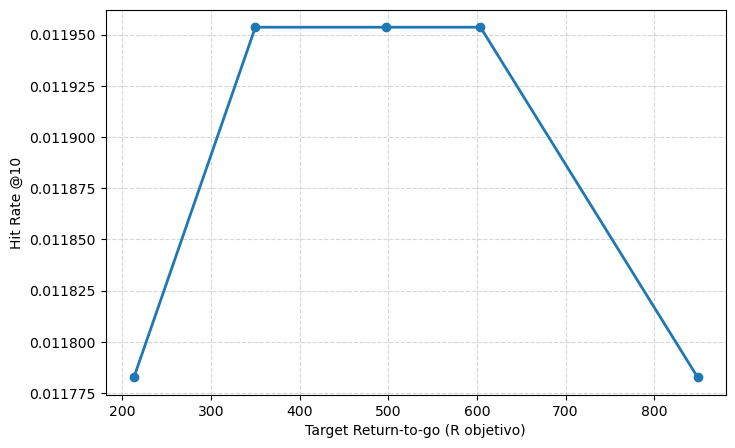

In [7]:
#Experimentos con valores de return to go
# Usamos train_trajectories y test_users que ya cargamos arriba.
trajectories = train_trajectories
test_data = test_users

# calcular percentiles de returns en training con numpy y los da en un diccionario
train_returns = [traj['returns_to_go'][0] for traj in trajectories]

percentiles = {
    'p25': np.percentile(train_returns, 25),
    'p50': np.percentile(train_returns, 50),
    'p75': np.percentile(train_returns, 75),
    'p90': np.percentile(train_returns, 90),
    'max': np.max(train_returns)
}
#los printeamos para verlos 
print("Percentiles:")
for name, value in percentiles.items():
    print(f"  {name}: {value:.2f}")

# Acá en este ciclito for la idea es qeu te calcula las metricas para cada target return
# y cada target retur es un percentil
results = {}
for name, rtg_value in percentiles.items():
    print(f"\nEvaluando con target_return = {name} (R={rtg_value:.2f})...")
    metrics = evaluate_model_batched(
        model=final_model,
        test_data=test_data,
        device=DEVICE,
        target_return=rtg_value  # k_list usa el default [5, 10, 20]
    )
    results[name] = metrics
    #y aca printeamos las metricas que venian del _baevaluate_model_batched
    print(f"  HR@10   = {metrics['HR@10']:.4f}")
    print(f"  NDCG@10 = {metrics['NDCG@10']:.4f}")
    print(f"  MRR     = {metrics['MRR']:.4f}")

# Graficar Return objetivo vs HR@10
rtg_values = list(percentiles.values())
hr10_values = [results[name]['HR@10'] for name in percentiles.keys()]

plt.figure(figsize=(8, 5))
plt.plot(rtg_values, hr10_values, marker='o', linewidth=2)
plt.xlabel('Target Return-to-go (R objetivo)')
plt.ylabel('Hit Rate @10')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Utilizando el percentil 75 hacemos un anàlisis por grupo.

In [8]:
# Usamos el percentil 75 de R_0 como target_return para todos los grupos porque alguno hay que usar. 
target_rtg_group = percentiles['p75'] #se puede hacer con otro si se cambia aca el percentil que se usa

results_by_group = {}

for group_id in range(8):
    # hacemos un if para sacar los usuarios que pertenecen al grupo encuestión
    users_in_group = [u for u in test_users if u['group'] == group_id]
    metrics = evaluate_model_batched(
        model=final_model,
        test_data=users_in_group,
        device=DEVICE,
        target_return=target_rtg_group,
        k_list=[5, 10, 20]
    )
    results_by_group[group_id] = metrics

    #aca lo cambié para que imprima toda las métricas 
    print(f"  HR@10   = {metrics['HR@10']:.4f}")
    print(f"  NDCG@10 = {metrics['NDCG@10']:.4f}")
    print(f"  MRR     = {metrics['MRR']:.4f}\n")

  HR@10   = 0.0150
  NDCG@10 = 0.0072
  MRR     = 0.0104

  HR@10   = 0.0150
  NDCG@10 = 0.0066
  MRR     = 0.0095

  HR@10   = 0.0109
  NDCG@10 = 0.0043
  MRR     = 0.0081

  HR@10   = 0.0096
  NDCG@10 = 0.0038
  MRR     = 0.0077

  HR@10   = 0.0068
  NDCG@10 = 0.0023
  MRR     = 0.0063

  HR@10   = 0.0137
  NDCG@10 = 0.0061
  MRR     = 0.0095

  HR@10   = 0.0109
  NDCG@10 = 0.0040
  MRR     = 0.0078

  HR@10   = 0.0137
  NDCG@10 = 0.0059
  MRR     = 0.0092

